## Long short-term memory(LSTM) Implementation univariate


### 1. Data Understanding and Exploration

Let's first import the required libraries and have a look at the dataset and understand the size, attribute names etc.

In [1]:
import numpy as np
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display_html
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
import re

C:\Users\u61152\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Build a function to get the data from the IMF website and save it locally

URL = 'http://www.imf.org/external/pubs/ft/weo/2020/01/weodata/WEOApr2020all.xls'
def get_data_from_IMF(URL):
    urllib.request.urlretrieve(URL, '.')

##### IMF's Data April 2020

In [4]:
# Reading the dataset
imf = pd.read_excel("data/WEOApr2020all.xls", na_values=['--'])


In [5]:
imf.shape

(1554, 52)

In [6]:
# Let's take a look at the first few rows
imf.head()

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Estimates Start After
0,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN,Source: National Statistics Office Latest actu...,NaN,...,5.683,2.697,0.988,2.164,2.889,2.664,3.037,-3.007,4.495,2018.0
1,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,Source: National Statistics Office Latest actu...,NaN,...,60.181,62.948,64.231,66.301,69.501,73.091,76.624,74.792,79.678,2018.0
2,512,AFG,NGDPRPPPPCPCH,Afghanistan,"Gross domestic product per capita, constant pr...",GDP is expressed in constant international dol...,Purchasing power parity; percent change,NaN,Source: National Statistics Office Latest actu...,NaN,...,2.236,-0.521,-1.941,-0.547,0.358,1.268,1.654,-4.291,3.063,2018.0
3,512,AFG,PCPIPCH,Afghanistan,"Inflation, average consumer prices",Annual percentages of average consumer prices ...,Percent change,NaN,Source: National Statistics Office Latest actu...,NaN,...,7.386,4.674,-0.662,4.384,4.976,0.626,2.302,4.711,4.451,2018.0
4,512,AFG,PCPIEPCH,Afghanistan,"Inflation, end of period consumer prices",Annual percentages of end of period consumer ...,Percent change,NaN,Source: National Statistics Office Latest actu...,NaN,...,7.241,1.487,1.131,4.588,3.041,0.755,2.773,4.500,5.000,2018.0


#### Understanding the Data Dictionary

The data dictionary contains the meaning of various attributes; some non-obvious ones are:

In [7]:
imf["Country"].unique().size

195

In [8]:
imf['Country'].astype('category').value_counts()

Zimbabwe           8
Egypt              8
Hong Kong SAR      8
Honduras           8
Haiti              8
                  ..
Oman               8
Norway             8
North Macedonia    8
Nigeria            8
Afghanistan        8
Name: Country, Length: 194, dtype: int64

In [9]:
imf['WEO Subject Code'].astype('category').value_counts()

PPPGDP           194
PCPIPCH          194
PCPIEPCH         194
NGDP_RPCH        194
NGDPRPPPPCPCH    194
LUR              194
GGXCNL_NGDP      194
BCA_NGDPD        194
Name: WEO Subject Code, dtype: int64

In [10]:
imf["WEO Subject Code"].unique()

array(['NGDP_RPCH', 'PPPGDP', 'NGDPRPPPPCPCH', 'PCPIPCH', 'PCPIEPCH',
       'LUR', 'GGXCNL_NGDP', 'BCA_NGDPD', nan], dtype=object)

In [11]:
imf['Subject Descriptor'].astype('category').value_counts()

Unemployment rate                                     194
Inflation, end of period consumer prices              194
Inflation, average consumer prices                    194
Gross domestic product, current prices                194
Gross domestic product, constant prices               194
Gross domestic product per capita, constant prices    194
General government net lending/borrowing              194
Current account balance                               194
Name: Subject Descriptor, dtype: int64

In [12]:
#print(imf.info())

In [13]:
# Few years data are the OBJECT type, lets convert those into float
#df_obj = imf.select_dtypes(include=[object])
#cols = imf.select_dtypes([np.object]).columns
filteredColumns = imf.dtypes[imf.dtypes == np.object]
listOfColumnNames = list(filteredColumns.index)
print(listOfColumnNames)
#list(df_obj.columns)

['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country', 'Subject Descriptor', 'Subject Notes', 'Units', 'Scale', 'Country/Series-specific Notes']


In [14]:
# check for NAN value
imf.isnull().sum()

WEO Country Code                    1
ISO                                 2
WEO Subject Code                    2
Country                             2
Subject Descriptor                  2
Subject Notes                       2
Units                               2
Scale                            1360
Country/Series-specific Notes      87
1980                              730
1981                              668
1982                              656
1983                              645
1984                              639
1985                              625
1986                              619
1987                              612
1988                              599
1989                              589
1990                              535
1991                              491
1992                              441
1993                              371
1994                              352
1995                              309
1996                              282
1997        

In [15]:
# Dropping scale column as it has too many NAN, And not have any business impact
imf = imf.drop(['Scale'], axis=1)

In [16]:
# check for missing values
# chek for unquie values
# check for data types

unique_values = imf.nunique()
filtered_empty = imf.isnull().sum(axis=0)
mis_val_percent = imf.isna().mean().round(4) * 100
data_type = imf.dtypes
val_table = pd.concat([unique_values,filtered_empty, mis_val_percent, data_type], axis=1,sort =True)
val_table_columns = val_table.rename(columns = {0: 'Unique', 1 : 'Missing Values', 2 : 'missing %', 3: 'type'})
val_table_columns = val_table_columns.sort_values('missing %', ascending=False)
val_table_columns 

,Unique,Missing Values,missing %,type
1980,808,730,46.98,float64
1981,855,668,42.99,float64
1982,874,656,42.21,float64
1983,878,645,41.51,float64
1984,886,639,41.12,float64
1985,892,625,40.22,float64
1986,902,619,39.83,float64
1987,911,612,39.38,float64
1988,922,599,38.55,float64
1989,934,589,37.90,float64


In [17]:
# we can see so many nulls in old data & years for few countries, since database is not big lets impute with zero for now
# we might modify or delete this step based on our model performance

imf = imf.fillna(0)


In [18]:
# we can notice some tail comments appended in last of the data file, lets remove
imf.drop(imf.loc[imf['ISO']==0].index, inplace=True)
imf.tail(2)

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Country/Series-specific Notes,1980,1981,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Estimates Start After
1550,698,ZWE,GGXCNL_NGDP,Zimbabwe,General government net lending/borrowing,Net lending (+)/ borrowing (?) is calculated a...,Percent of GDP,Source: Ministry of Finance or Treasury Latest...,0.0,0.0,...,-0.621,-0.421,-1.418,-6.242,-8.113,-4.499,-2.575,-4.931,-1.518,2018.0
1551,698,ZWE,BCA_NGDPD,Zimbabwe,Current account balance,Current account is all transactions other than...,Percent of GDP,Source: Reserve Bank of Zimbabwe and Ministry ...,0.0,0.0,...,-13.230,-11.563,-7.617,-3.580,-1.299,-5.896,1.133,-1.914,-1.894,2018.0


In [19]:
# Row wise Null
#imf.isnull().all(axis = 1).sum()

In [20]:
# Lets drop few columns on business justification as those are of no use in inference
# "Estimates Start After"
# "Subject Notes"
# "Country/Series-specific Notes"

In [21]:
imf.drop(['Estimates Start After','Subject Notes','Country/Series-specific Notes'] , axis=1, inplace=True)
imf.head(2)

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Units,1980,1981,1982,1983,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Percent change,0.0,0.0,0.0,0.0,...,13.968,5.683,2.697,0.988,2.164,2.889,2.664,3.037,-3.007,4.495
1,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",Purchasing power parity; international dollars,0.0,0.0,0.0,0.0,...,55.963,60.181,62.948,64.231,66.301,69.501,73.091,76.624,74.792,79.678


In [22]:
#imf = imf.select_dtypes(include ='float64') 
#imf.head()

In [23]:
# remove all the catagorical varible to plot
unique_values = imf.nunique()
filtered_empty = imf.isnull().sum(axis=0)
mis_val_percent = imf.isna().mean().round(4) * 100
data_type = imf.dtypes
val_table = pd.concat([unique_values,filtered_empty, mis_val_percent, data_type], axis=1,sort =True)
val_table_columns = val_table.rename(columns = {0: 'Unique', 1 : 'Missing Values', 2 : 'missing %', 3: 'type'})
val_table_columns = val_table_columns.sort_values('missing %', ascending=False)
val_table_columns 

,Unique,Missing Values,missing %,type
WEO Country Code,194,0,0.0,object
ISO,194,0,0.0,object
2000,1319,0,0.0,float64
2001,1345,0,0.0,float64
2002,1367,0,0.0,float64
2003,1367,0,0.0,float64
2004,1390,0,0.0,float64
2005,1381,0,0.0,float64
2006,1385,0,0.0,float64
2007,1396,0,0.0,float64


In [24]:
imf["Subject Descriptor"].unique()

array(['Gross domestic product, constant prices',
       'Gross domestic product, current prices',
       'Gross domestic product per capita, constant prices',
       'Inflation, average consumer prices',
       'Inflation, end of period consumer prices', 'Unemployment rate',
       'General government net lending/borrowing',
       'Current account balance'], dtype=object)

In [25]:
imf["WEO Subject Code"].unique()

array(['NGDP_RPCH', 'PPPGDP', 'NGDPRPPPPCPCH', 'PCPIPCH', 'PCPIEPCH',
       'LUR', 'GGXCNL_NGDP', 'BCA_NGDPD'], dtype=object)

In [26]:
#so there is no use of subject code, we will use descriptor, lets remove code
imf.drop(['WEO Subject Code'] , axis=1, inplace=True)
#there is no use of year 2021,since we have to predict it, lets remove
imf.drop([2021] , axis=1, inplace=True)

In [27]:
imf.head(2)

,WEO Country Code,ISO,Country,Subject Descriptor,Units,1980,1981,1982,1983,1984,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,512,AFG,Afghanistan,"Gross domestic product, constant prices",Percent change,0.0,0.0,0.0,0.0,0.0,...,6.479,13.968,5.683,2.697,0.988,2.164,2.889,2.664,3.037,-3.007
1,512,AFG,Afghanistan,"Gross domestic product, current prices",Purchasing power parity; international dollars,0.0,0.0,0.0,0.0,0.0,...,48.180,55.963,60.181,62.948,64.231,66.301,69.501,73.091,76.624,74.792


In [28]:
# Now we will try to take each indicator one by one, lets rename subject descriptor to economy indicators
imf["Subject Descriptor"].unique()
imf.rename(columns = {'Subject Descriptor':'Economic Indicator'}, inplace = True) 

In [29]:
imf.head(2)

,WEO Country Code,ISO,Country,Economic Indicator,Units,1980,1981,1982,1983,1984,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,512,AFG,Afghanistan,"Gross domestic product, constant prices",Percent change,0.0,0.0,0.0,0.0,0.0,...,6.479,13.968,5.683,2.697,0.988,2.164,2.889,2.664,3.037,-3.007
1,512,AFG,Afghanistan,"Gross domestic product, current prices",Purchasing power parity; international dollars,0.0,0.0,0.0,0.0,0.0,...,48.180,55.963,60.181,62.948,64.231,66.301,69.501,73.091,76.624,74.792


####  Split data across each economic indicator


In [30]:
# Gross domestic product, constant prices
imf_gdp_constant_price = imf[imf['Economic Indicator']=='Gross domestic product, constant prices']
#Gross domestic product, current prices
imf_gdp_current_price = imf[imf['Economic Indicator']=='Gross domestic product, current prices']
# Gross domestic product per capita, constant prices
imf_gdp_per_capita_con_price = imf[imf['Economic Indicator']=='Gross domestic product per capita, constant prices']
# Inflation, average consumer prices
imf_inflation_avg_con_prices = imf[imf['Economic Indicator']=='Inflation, average consumer prices']
# Inflation, end of period consumer prices
imf_inflation_eop_con_prices = imf[imf['Economic Indicator']=='Inflation, end of period consumer prices']
# Unemployment rate
imf_unemployment = imf[imf['Economic Indicator']=='Unemployment rate']
# General government net lending/borrowing
imf_gov_len_bor = imf[imf['Economic Indicator']=='General government net lending/borrowing']
# Current account balance
imf_current_acc_bal = imf[imf['Economic Indicator']=='Current account balance']

In [31]:
imf_gdp_constant_price.head(2)

,WEO Country Code,ISO,Country,Economic Indicator,Units,1980,1981,1982,1983,1984,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,512,AFG,Afghanistan,"Gross domestic product, constant prices",Percent change,0.000,0.0,0.0,0.0,0.0,...,6.479,13.968,5.683,2.697,0.988,2.164,2.889,2.664,3.037,-3.007
8,914,ALB,Albania,"Gross domestic product, constant prices",Percent change,2.684,5.7,2.9,1.1,2.0,...,2.545,1.418,1.002,1.774,2.219,3.315,3.802,4.071,2.214,-5.006


In [32]:
#pv2 = pd.pivot_table(imf_gdp_constant_price,index=['Series Name','ISO'], dropna=False, fill_value=0.0)

In [33]:
#pv2.columns= np.arange(1990,2016)

##### Remove categorical variable
###### Since we have country name, we don't need any other variable for row-wise uniqueness

In [34]:
imf_gdp_constant_price.drop(['ISO','WEO Country Code','Economic Indicator', 'Units'] , axis=1, inplace=True)
imf_gdp_current_price.drop(['ISO','WEO Country Code','Economic Indicator', 'Units'] , axis=1, inplace=True)
imf_gdp_per_capita_con_price.drop(['ISO','WEO Country Code','Economic Indicator', 'Units'] , axis=1, inplace=True)
imf_inflation_avg_con_prices.drop(['ISO','WEO Country Code','Economic Indicator', 'Units'] , axis=1, inplace=True)
imf_inflation_eop_con_prices.drop(['ISO','WEO Country Code','Economic Indicator', 'Units'] , axis=1, inplace=True)
imf_unemployment.drop(['ISO','WEO Country Code','Economic Indicator', 'Units'] , axis=1, inplace=True)
imf_gov_len_bor.drop(['ISO','WEO Country Code','Economic Indicator', 'Units'] , axis=1, inplace=True)
imf_current_acc_bal.drop(['ISO','WEO Country Code','Economic Indicator', 'Units'] , axis=1, inplace=True)

In [35]:
imf_gdp_constant_price

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Afghanistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,6.479,13.968,5.683,2.697,0.988,2.164,2.889,2.664,3.037,-3.007
8,Albania,2.684,5.700,2.900,1.100,2.000,-1.500,5.600,-0.800,-1.400,...,2.545,1.418,1.002,1.774,2.219,3.315,3.802,4.071,2.214,-5.006
16,Algeria,-5.400,3.000,6.400,5.400,5.600,5.600,-0.200,-0.700,-1.900,...,2.823,3.391,2.800,3.800,3.700,3.200,1.300,1.400,0.700,-5.157
24,Angola,2.406,-4.400,0.000,4.200,6.000,3.500,2.900,4.083,6.129,...,3.472,8.542,4.955,4.823,0.944,-2.580,-0.150,-1.200,-1.503,-1.374
32,Antigua and Barbuda,8.161,3.815,-0.084,5.364,10.165,7.644,11.494,6.626,5.213,...,-1.959,3.372,-0.601,3.797,3.824,5.498,3.145,7.389,5.264,-9.998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,Venezuela,-4.947,-1.288,2.645,-9.856,5.223,0.867,6.080,4.801,6.510,...,4.176,5.626,1.343,-3.894,-6.221,-17.040,-15.671,-19.621,-35.000,-15.000
1520,Vietnam,-3.497,5.797,8.150,7.093,8.397,5.619,3.357,2.549,5.100,...,6.413,5.505,5.554,6.422,6.987,6.690,6.940,7.076,7.017,2.700
1528,Yemen,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-12.715,2.393,4.824,-0.189,-27.995,-9.375,-5.072,0.752,2.100,-3.000
1536,Zambia,3.854,6.631,-2.912,-1.145,-1.718,1.237,1.698,1.491,9.271,...,5.565,7.598,5.057,4.698,2.920,3.757,3.524,4.035,1.520,-3.507


In [36]:
imf_gdp_constant_price.index

Int64Index([   0,    8,   16,   24,   32,   40,   48,   56,   64,   72,
            ...
            1472, 1480, 1488, 1496, 1504, 1512, 1520, 1528, 1536, 1544],
           dtype='int64', length=194)

##### Split data into train & test

In [37]:
#imf_gdp_constant_price.columns

In [38]:
def display_table(df1, df2, name1 , name2):
    styles = [
    dict(selector="th", props=[("font-size", "100%"),("text-align", "center")]),
    dict(selector="caption", props=[("font-size", "110%"),("text-align", "center"),("font-weight", "bold")])
    ]
    
    df1_sty = df1.style.set_table_styles(styles).set_caption(name1).set_table_attributes("style='display:inline'")
    df2_sty = df2.style.set_table_styles(styles).set_caption(name2).set_table_attributes("style='display:inline'")
 
    return display_html(df1_sty._repr_html_()+"\xa0\xa0\xa0\xa0\xa0\xa0"+df2_sty._repr_html_(), raw=True)

In [39]:
#imf_gdp_constant_price_4_years_train.shape

In [40]:
def get_input_data(input):
    nb_timesteps = 4
    flag = 0
    for sample in range(input.shape[0]):
        tmp = np.array([input[sample,i:i+nb_timesteps,:] for i in range(input.shape[1] - nb_timesteps + 1)])
        if flag==0:
            new_input = tmp
            flag = 1
        else:
            new_input = np.concatenate((new_input,tmp))
    return new_input

In [41]:
imf_gdp_constant_price.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Afghanistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,6.479,13.968,5.683,2.697,0.988,2.164,2.889,2.664,3.037,-3.007
8,Albania,2.684,5.700,2.900,1.100,2.000,-1.500,5.600,-0.800,-1.400,...,2.545,1.418,1.002,1.774,2.219,3.315,3.802,4.071,2.214,-5.006
16,Algeria,-5.400,3.000,6.400,5.400,5.600,5.600,-0.200,-0.700,-1.900,...,2.823,3.391,2.800,3.800,3.700,3.200,1.300,1.400,0.700,-5.157
24,Angola,2.406,-4.400,0.000,4.200,6.000,3.500,2.900,4.083,6.129,...,3.472,8.542,4.955,4.823,0.944,-2.580,-0.150,-1.200,-1.503,-1.374
32,Antigua and Barbuda,8.161,3.815,-0.084,5.364,10.165,7.644,11.494,6.626,5.213,...,-1.959,3.372,-0.601,3.797,3.824,5.498,3.145,7.389,5.264,-9.998


In [42]:
imf_gdp_current_price.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
1,Afghanistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,48.180,55.963,60.181,62.948,64.231,66.301,69.501,73.091,76.624,74.792
9,Albania,5.563,6.437,7.033,7.388,7.808,7.934,8.547,8.689,8.869,...,28.616,29.578,30.398,31.510,32.545,33.972,35.928,38.301,39.832,38.078
17,Algeria,86.890,97.964,110.674,121.219,132.626,144.483,147.097,149.680,152.014,...,478.300,504.004,527.206,557.368,584.008,608.937,628.470,652.795,668.827,638.363
25,Angola,10.310,10.789,11.456,12.404,13.623,14.546,15.269,16.285,17.893,...,153.714,170.045,181.601,193.882,197.749,194.641,198.009,200.400,200.830,199.329
33,Antigua and Barbuda,0.268,0.304,0.323,0.353,0.403,0.448,0.509,0.556,0.606,...,1.774,1.869,1.890,1.998,2.097,2.235,2.348,2.583,2.767,2.506


##### lets choose one country at a time to prepare the data for LSTM input

In [43]:
imf_gdp_current_price_ind = imf_gdp_current_price[imf_gdp_current_price['Country']=='India']

In [44]:
imf_gdp_constant_price_ind = imf_gdp_constant_price[imf_gdp_constant_price['Country']=='India']

In [45]:
imf_gdp_per_capita_con_price_ind = imf_gdp_per_capita_con_price[imf_gdp_per_capita_con_price['Country']=='India']

In [46]:
imf_inflation_avg_con_prices_ind = imf_inflation_avg_con_prices[imf_inflation_avg_con_prices['Country']=='India']

In [47]:
imf_inflation_eop_con_prices_ind = imf_inflation_eop_con_prices[imf_inflation_eop_con_prices['Country']=='India']

In [48]:
imf_unemployment_ind = imf_unemployment[imf_unemployment['Country']=='India']

In [49]:
imf_gov_len_bor_ind = imf_gov_len_bor[imf_gov_len_bor['Country']=='India']

In [50]:
def get_country(country_name, indicator):
    country_indicator = country_name+"_"+indicator
    return country_indicator

In [51]:
print(get_country('US','gdp'))

US_gdp


In [52]:
imf_gdp_current_price_ind.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
609,India,383.126,444.562,488.436,544.561,585.769,636.047,679.845,724.285,822.018,...,5782.04,6214.49,6727.34,7359.58,8030.82,8783.89,9579.69,10413.61,11043.18,11321.28


In [53]:
imf_gdp_constant_price_ind.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
608,India,5.281,6.006,3.476,7.289,3.821,5.254,4.777,3.965,9.628,...,6.638,5.456,6.386,7.41,7.996,8.256,7.044,6.12,4.228,1.871


In [54]:
imf_gdp_per_capita_con_price_ind.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
610,India,3.131,3.81,1.234,5.014,1.597,3.047,2.559,1.746,7.337,...,5.19,4.055,5.005,6.015,6.594,6.851,5.654,4.742,2.875,0.548


In [55]:
imf_inflation_avg_con_prices_ind.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
611,India,11.346,12.654,7.736,12.558,6.517,6.251,8.889,9.059,7.214,...,9.5,10.0,9.4,5.8,4.9,4.5,3.602,3.428,4.536,3.342


In [56]:
imf_inflation_eop_con_prices_ind.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
612,India,12.819,9.048,10.42,10.398,5.144,8.92,7.464,9.743,5.04,...,8.781,10.488,7.663,5.272,5.259,3.569,4.594,2.465,5.766,2.734


In [57]:
imf_unemployment_ind.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
613,India,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
imf_gov_len_bor_ind.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
614,India,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.89,...,-8.349,-7.55,-7.0,-7.071,-7.203,-7.118,-6.361,-6.27,-7.442,-7.422


In [59]:
imf_gdp_current_price_ind.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
609,India,383.126,444.562,488.436,544.561,585.769,636.047,679.845,724.285,822.018,...,5782.04,6214.49,6727.34,7359.58,8030.82,8783.89,9579.69,10413.61,11043.18,11321.28


In [60]:
#get_input_data(imf_gdp_current_price_ind)

In [61]:
imf_gdp_current_price_ind.drop(['Country'] , axis=1, inplace=True)

In [62]:
imf_gdp_current_price_ind.head()

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
609,383.126,444.562,488.436,544.561,585.769,636.047,679.845,724.285,822.018,905.053,...,5782.04,6214.49,6727.34,7359.58,8030.82,8783.89,9579.69,10413.61,11043.18,11321.28


In [63]:
df = imf_gdp_current_price_ind.rename(columns=imf_gdp_current_price_ind.iloc[0])

In [64]:
df

,383.126,444.562,488.436,544.561,585.769,636.047,679.845,724.285,822.018,905.053,...,5782.040,6214.490,6727.340,7359.580,8030.820,8783.890,9579.690,10413.610,11043.180,11321.280
609,383.126,444.562,488.436,544.561,585.769,636.047,679.845,724.285,822.018,905.053,...,5782.04,6214.49,6727.34,7359.58,8030.82,8783.89,9579.69,10413.61,11043.18,11321.28


In [65]:
imf_gdp_current_price_ind.reset_index(drop=True, inplace=True)
imf_gdp_current_price_ind

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,383.126,444.562,488.436,544.561,585.769,636.047,679.845,724.285,822.018,905.053,...,5782.04,6214.49,6727.34,7359.58,8030.82,8783.89,9579.69,10413.61,11043.18,11321.28


In [66]:
#newData = pd.concat([pd.DataFrame([np_row[0 , i+1 : i+6]]) for i in range(38)], ignore_index=True)
#newData.head(40)
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
    X, y =[],[]
    for i in range(len(timeseries_data)):
        # find the end of this pattern
        end_ix = i + n_features
        # check if we are beyond the sequence
        if end_ix > len(timeseries_data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [67]:
#newData = pd.concat([pd.DataFrame([np_row[0 , i+1 : i+6]]) for i in range(38)], ignore_index=True)
#newData.head(40)
# preparing independent and dependent features
def prepare_dataa(timeseries_data, n_features):
    X, y =[],[]
    for i in range(len(timeseries_data)):
        # find the end of this pattern
        end_ix = i + n_features
        # check if we are beyond the sequence
        if end_ix > len(timeseries_data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [68]:
# define input sequence
# choose a number of time steps
n_steps = 4
# split into samples
x_data, y_data = prepare_dataa(imf_gdp_current_price_ind.values.flatten(), n_steps)

In [69]:
print(x_data)

[[  383.126   444.562   488.436   544.561]
 [  444.562   488.436   544.561   585.769]
 [  488.436   544.561   585.769   636.047]
 [  544.561   585.769   636.047   679.845]
 [  585.769   636.047   679.845   724.285]
 [  636.047   679.845   724.285   822.018]
 [  679.845   724.285   822.018   905.053]
 [  724.285   822.018   905.053   990.883]
 [  822.018   905.053   990.883  1035.22 ]
 [  905.053   990.883  1035.22   1116.86 ]
 [  990.883  1035.22   1116.86   1197.64 ]
 [ 1035.22   1116.86   1197.64   1304.66 ]
 [ 1116.86   1197.64   1304.66   1432.91 ]
 [ 1197.64   1304.66   1432.91   1569.31 ]
 [ 1304.66   1432.91   1569.31   1661.02 ]
 [ 1432.91   1569.31   1661.02   1783.6  ]
 [ 1569.31   1661.02   1783.6    1962.48 ]
 [ 1661.02   1783.6    1962.48   2086.1  ]
 [ 1783.6    1962.48   2086.1    2237.26 ]
 [ 1962.48   2086.1    2237.26   2361.45 ]
 [ 2086.1    2237.26   2361.45   2596.38 ]
 [ 2237.26   2361.45   2596.38   2875.56 ]
 [ 2361.45   2596.38   2875.56   3240.42 ]
 [ 2596.38 

In [70]:
print(y_data)

[  585.769   636.047   679.845   724.285   822.018   905.053   990.883
  1035.22   1116.86   1197.64   1304.66   1432.91   1569.31   1661.02
  1783.6    1962.48   2086.1    2237.26   2361.45   2596.38   2875.56
  3240.42   3647.77   4112.91   4356.04   4761.46   5311.15   5782.04
  6214.49   6727.34   7359.58   8030.82   8783.89   9579.69  10413.61
 11043.18  11321.28 ]


In [71]:
x_data.shape

(37, 4)

In [72]:
y_data.shape

(37,)

In [73]:
from sklearn.model_selection import train_test_split
train_x, test_x = train_test_split(x_data, test_size=0.2)
train_y, test_y = train_test_split(y_data, test_size=0.2)

In [74]:
train_x.shape

(29, 4)

In [75]:
train_y.shape

(29,)

In [76]:
test_y.shape

(8,)

In [77]:
test_y.shape

(8,)

In [78]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
#X
train_scaled_x = scaler.fit_transform(np.float32(train_x))
train_x = pd.DataFrame(train_scaled_x)
test_scaled_x = scaler.transform(np.float32(test_x))
test_x = pd.DataFrame(test_scaled_x)

#Y
# without reshape we can't pass to fit transform
train_scaled_y = scaler.fit_transform(train_y.reshape(-1, 1))
train_y = pd.DataFrame(train_scaled_y)
test_scaled_y = scaler.transform(np.float32(test_y.reshape(-1, 1)))
test_y = pd.DataFrame(test_scaled_y)

display_table(train_x, train_y,"X Train Set", " Y Train set")

,0,1,2,3
0,0.296691,0.306056,0.318315,0.339887
1,0.642669,0.631620,0.628594,0.649135
2,0.007313,0.004803,0.005655,0.003925
3,0.388613,0.401565,0.389676,0.401662
4,0.109696,0.108192,0.108902,0.106343
5,0.052244,0.050409,0.050623,0.046736
6,0.072345,0.064658,0.063316,0.062206
7,0.024122,0.020961,0.019285,0.017119
8,0.755195,0.756970,0.759925,0.784801
9,0.188001,0.179695,0.176201,0.173060


In [79]:
display_table(test_x, test_y,"X Test Set", " Y Test set")

X Test Set 0 1 2 3 
 
 0 
 0.152116 
 0.146581 
 0.148516 
 0.146833 
 
 
 1 
 0.077623 
 0.073595 
 0.071455 
 0.072400 
 
 
 2 
 0.124963 
 0.123123 
 0.118142 
 0.118019 
 
 
 3 
 0.062129 
 0.059804 
 0.055091 
 0.054512 
 
 
 4 
 0.019217 
 0.015458 
 0.014872 
 0.012886 
 
 
 5 
 0.694147 
 0.687760 
 0.692294 
 0.713071 
 
 
 6 
 0.830455 
 0.830449 
 0.835799 
 0.860602 
 
 
 7 
 0.340123 
 0.350647 
 0.365180 
 0.363046 
 
        Y Test set 0 
 
 0 
 0.834173 
 
 
 1 
 0.109409 
 
 
 2 
 0.032488 
 
 
 3 
 0.100077 
 
 
 4 
 0.168042 
 
 
 5 
 1.064060 
 
 
 6 
 0.270115 
 
 
 7 
 1.092357

In [80]:
train_x.shape

(29, 4)

In [81]:
test_x.shape

(8, 4)

In [82]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = train_x.values.reshape((train_x.shape[0], train_x.shape[1], n_features))
y_train = train_y.values.reshape((train_y.shape[0], n_features))
X_test = test_x.values.reshape((test_x.shape[0], test_x.shape[1], n_features))
y_test = test_y.values.reshape((test_y.shape[0], n_features))
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((29, 4, 1), (29, 1), (8, 4, 1), (8, 1))

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(4, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
print(model.summary())

In [83]:
def build_lstm_model(input_size, output_size, neurons, activ_func,dropout, loss, optimizer):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_size.shape[1], input_size.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [84]:
np.random.seed(42)
window_len = 4
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'nadam'
output_size = 1
activ_func = 'relu'

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [85]:
#model = build_model2([3,4,1])
model = build_lstm_model(X_train, output_size, lstm_neurons,activ_func, dropout, loss, optimizer)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [86]:
#model.fit(X_train, Y_train, epochs=2000, validation_split=0.2, batch_size=5)
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





29/29 [==============================] - 1s 36ms/step - loss: 0.1612
Epoch 2/20
29/29 [==============================] - 0s 208us/step - loss: 0.1450
Epoch 3/20
29/29 [==============================] - 0s 205us/step - loss: 0.1324
Epoch 4/20
29/29 [==============================] - 0s 222us/step - loss: 0.1235
Epoch 5/20
29/29 [==============================] - 0s 229us/step - loss: 0.1172
Epoch 6/20
29/29 [==============================] - 0s 241us/step - loss: 0.1107
Epoch 7/20
29/29 [==============================] - 0s 200us/step - loss: 0.1054
Epoch 8/20
29/29 [==============================] - 0s 188us/step - loss: 0.0986
Epoch 9/20
29/29 [==============================] - 0s 171us/step - loss: 0.1003
Epoch 10/20
29/29 [==============================] - 0s 172us/step - loss: 0.0969
Epoch 11/20
29/29 [==============================] - 0s 241us/step - loss: 0.0968
Epoch 

In [87]:
#targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.35514897

preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

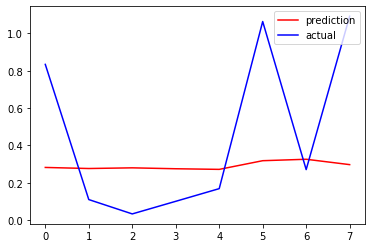

In [88]:
import matplotlib.pyplot as plt2

plt2.plot(preds,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='actual')
plt2.legend(loc='upper right')
plt2.show()

In [89]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
